In [20]:
import scanpy as sc
import pandas as pd
import sys
from scipy.stats import pearsonr
#from generate_gene_block import plot_gene_block
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from matplotlib.lines import Line2D

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 200)

In [2]:
adata_de = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
de_by_guide = pd.read_csv('../3_DE_analysis/results/DE_by_guide.correlation_results.csv', index_col=0)
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [3]:
pb = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final/CD4i_final_merged.DE_pseudobulk_corrected.h5ad', backed='r')

In [262]:
mpl.rcParams['font.family'] = 'NimbusSanL'
def plot_gene_block(gene_name: str, measurements: np.ndarray, vmin=-0.8, vmax=0.8,
                    colormap: str = 'BrBG_r', figsize=(2,1), incluster=True, output_filename: str = None):
    """
    Generates a 1x2 gene visualization block with a central gene name overlay.

    The color of each block (Left and Right) corresponds to the value in the 
    'measurements' array, mapped via the specified colormap.

    Args:
        gene_name (str): The name of the gene (e.g., 'MAP4K1').
        measurements (np.ndarray): A 1D NumPy array of two numerical values, 
                                   representing the measurement for each block.
                                   Structure: [Left_Block, Right_Block]
        colormap (str): The matplotlib colormap to use (e.g., 'Reds', 'viridis', etc.).
    """
    # 1. Setup the figure and axis
    # Adjusted figsize for a 1x2 horizontal look
    fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
    
    # Reshape the 1D array (2 elements) into a 1x2 2D array for imshow.
    data_2d = measurements.reshape(1, 2)

    # 2. Plot the 1x2 data using imshow (creates the colored blocks)
    # extent=[xmin, xmax, ymin, ymax]. x runs from 0 to 2, y runs from 0 to 1.
    img = ax.imshow(data_2d, cmap=colormap, vmin=vmin, vmax=vmax, 
                    interpolation='nearest', extent=[0, figsize[0], 0, figsize[1]]) 

    # 3. Apply plot aesthetics and add black line borders/separators
    ax.set_xticks([]) # Remove x ticks
    ax.set_yticks([]) # Remove y ticks

    if incluster:
        line_style = '-'
        line_width = 3.5
        font_weight = 'bold'
        custom_dashes = [2,0]
    else:
        line_style = '--'
        line_width = 3.5
        font_weight = 'normal'
        custom_dashes = [2,2]
    
    # Set all spines (outer borders) to be visible and black
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
        spine.set_linestyle(line_style)
        spine.set_edgecolor('black')
        spine.set_visible(True)
        #spine.set_linestyle((0, custom_dashes))
    
    # Add a black vertical line to separate the two blocks (at x=1.0)
    
    line = Line2D([figsize[0]/2, figsize[0]/2], [0, figsize[1]], color='black', linewidth=line_width/2, zorder=1)
    line.set_linestyle((0, custom_dashes)) # Apply custom dashes
    ax.add_line(line)

    # Ensure the aspect ratio and limits are correct
    ax.set_xlim(0, figsize[0])
    ax.set_ylim(0, figsize[1]) # Y-limit is now 1 for the 1x2 shape

    # 4. Draw the central white box (Rectangle patch)
    # The center of the 1x2 grid is now at (1.0, 0.5)
    box_width = 1.7
    box_height = 0.5
    center_x = figsize[0]/2
    center_y = figsize[1]/2
    
    # Create the white rectangle
    rect = patches.Rectangle(
        (center_x - box_width/2, center_y - box_height/2),  # (x, y) starting point (bottom-left)
        box_width, 
        box_height,
        linewidth=line_width/2,
        linestyle=line_style,
        edgecolor='black', # Border color
        facecolor='white', # Fill color
        zorder=2 # Ensure the box is above the colored blocks
    )
    rect.set_linestyle((0, custom_dashes)) 
    ax.add_patch(rect)

    if len(gene_name)<8:
        fontsize=24
    else:
        fontsize=20
    # 5. Add the gene name text
    ax.text(
        center_x, center_y*0.95,
        gene_name,
        color='black',
        fontsize=fontsize,
        fontweight=font_weight,
        ha='center', # Horizontal alignment: Center
        va='center', # Vertical alignment: Center
        zorder=3 # Ensure text is above the white box
    )

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # 6. Show the plot (or save it)
    if output_filename:
        # Save the figure with tight bounding box and high resolution (300 DPI)
        plt.savefig(output_filename,
                    bbox_inches='tight',
                    pad_inches=0,
                    dpi=300)
        plt.close(fig) # Close the figure to free memory
        print(f"Figure successfully saved to {output_filename}")
    else:
        plt.show()

In [253]:
# Define core TCR signaling genes
core_tcr = ['CD3D', 'CD3E', 'CD3G', 'CD247', 'ZAP70', 'LAT', 'VAV1', 'LCP2', 'PLCG1']
core_tcr_geneid = adata_final[adata_final.obs.target_contrast_gene_name_corrected.isin(core_tcr)].obs.target_contrast_corrected.unique().tolist()
core_tcr_geneid_stim8hr = [item+'_Stim8hr' for item in core_tcr_geneid]
core_tcr_geneid_stim48hr = [item+'_Stim48hr' for item in core_tcr_geneid]

In [254]:
np.where(np.array(genename_list)=='CYB561D2')[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

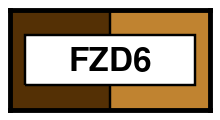

In [263]:
cl = 21
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
i = 20
for geneid in geneid_list[i:i+1]:
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        ind = np.where(np.array(geneid_list)==geneid)[0][0]
        plot_gene_block(genename_list[ind], sample_measurements, colormap='BrBG_r', vmin=-0.7, vmax=0.7, incluster=True)

In [265]:
cl = 21
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        plot_gene_block(genename_list[i], sample_measurements, colormap='BrBG_r', vmin=-0.7, vmax=0.7, incluster=True,
                        output_filename='./results/for_TCR_schematics/'+genename_list[i]+'_cluster'+str(cl)+'.pdf')

Figure successfully saved to ./results/for_TCR_schematics/COG5_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/ATXN7L3_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/EML2_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/USP22_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/RAC2_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/CAMSAP1_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/LCK_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/RAB19_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/DCAF11_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/TMEM205_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/ACTR2_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/FAM204A_cluster21.pdf
Figure successfully saved to ./results/for_TCR_schematics/NU

In [63]:
cl = 60
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if ((sample_measurements[1] - sample_measurements[0])>0.4) or ((sample_measurements[0] - sample_measurements[1])>0.4):
            plot_gene_block(genename_list[i], sample_measurements, colormap='vlag', vmin=-0.6, vmax=0.6, incluster=True,
                            output_filename='./results/for_TCR_schematics/a_'+genename_list[i]+'_cluster'+str(cl)+'.pdf')

Figure successfully saved to ./results/for_TCR_schematics/a_PTPN1_cluster60.pdf
Figure successfully saved to ./results/for_TCR_schematics/a_ITM2A_cluster60.pdf
Figure successfully saved to ./results/for_TCR_schematics/a_TIMM10_cluster60.pdf
Figure successfully saved to ./results/for_TCR_schematics/a_RWDD2B_cluster60.pdf
Figure successfully saved to ./results/for_TCR_schematics/a_EIF1AX_cluster60.pdf
Figure successfully saved to ./results/for_TCR_schematics/a_MAP3K1_cluster60.pdf
Figure successfully saved to ./results/for_TCR_schematics/a_CCDC138_cluster60.pdf


In [71]:
cl = 77
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if (sample_measurements[0]<-0.2) or (sample_measurements[0]<-0.2):
            plot_gene_block(genename_list[i], sample_measurements, colormap='vlag', vmin=-0.6, vmax=0.6, incluster=True,
                            output_filename='./results/for_TCR_schematics/ai_'+genename_list[i]+'_cluster'+str(cl)+'.pdf')

Figure successfully saved to ./results/for_TCR_schematics/ai_HOXC10_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_FRS3_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_ATG9A_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_BZW2_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_RIC8A_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_SLC4A7_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_ITPR1_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_PAN3_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_PARK7_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_GOLGA8N_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_CTH_cluster77.pdf
Figure successfully saved to ./results/for_TCR_schematics/ai_INSIG1_cluster77.pdf
Figure successfully saved to

In [84]:
print(set(['ATXN7L3', 'EML2', 'USP22', 'RAC2', 'CAMSAP1', 'DCAF11', 'TMEM205', 'ACTR2', 'FAM204A', 'NUDCD1', 'CDS2', 'SCAF4', 'ZNF790', 'CRIPT', 
    'SENP1', 'KIDINS220', 'BRPF1', 'ATP2A3', 'PPP3R1', 'TMX1', 'IKZF1', 'PIGB', 'SPTLC2', 'CBLL1', 'PHF19', 'DIPK1A', 'SHOC2', 'FLVCR2', 'EIF4G2', 'ZSCAN23',
    'RAVER1', 'TASOR', 'MED23', 'ING5', 'PDIA3', 'HACD4', 'DZIP1', 'ANKRD61', 'MCFD2', 'HSD17B12', 'CALCOCO2', 'BCAP29', 'KAT6A', 'TLN1', 'DDX60L', 'TBX22', 'ARPC2',
    'ERCC6L2', 'YIPF1', 'STIM1', 'CDIPT', 'ARPC3', 'ABHD17A', 'HELT', 'TTC7A', 'COP1', 'PPP1R10', 'CYB5R4', 'PEX5', 'NFATC2', 'ITK', 'RBM33', 'NATD1', 'NDFIP2', 'RNF19B',
    'NKAPD1', 'BLOC1S4', 'TMED9', 'TXNL1', 'XPR1', 'NABP1', 'TSC2', 'HEXD', 'CHURC1', 'SOS2', 'PLIN4', 'VPS35', 'UBIAD1', 'GPR137', 'DNAJC8', 'ORAI1', 'CARMIL2', 'THAP12',
    'MALT1', 'VPS29', 'CARD11', 'COG6', 'RREB1', 'CD2', 'C8orf82', 'MED14', 'MAP3K5', 'BICDL1', 'C1D', 'ATXN7L3', 'COPS9', 'ATRX', 'LSS', 'CD3E', 'PEX5', 'CCN1', 'GSS',
    'OST4', 'PHF6', 'JUNB', 'CEP135', 'SRSF11', 'N6AMT1', 'EIF1', 'NUP37', 'EWSR1', 'TNRC6A', 'FANCL', 'RNASEH2A', 'CD247', 'CD3G', 'CLCC1', 'NKAPD1', 'TBX22',
    'NR4A3', 'TMEM140', 'MED23', 'XRCC2', 'ARL6IP1', 'IKBKB', 'NDFIP2', 'PCYT2', 'ATP1B3', 'CAMSAP1', 'KGD4', 'WNK1', 'RNF8', 'PLCG1', 'KMT2E', 'ZRANB2', 'FBRS', 'ST8SIA1',
    'CNOT6L', 'ERCC1', 'NCAPG2', 'LSM12', 'FANCB', 'NFIX', 'DCAF5', 'NUP188', 'ELOB', 'PRKCQ', 'TFAP4', 'PTPRC', 'PHF23', 'SHOC2', 'ZNF703', 'TMEM263', 'HELT',
    'ICE2', 'METTL23', 'CLDN7','KAT6A', 'OTUB1', 'DCAF4', 'FBXW7', 'FDX1', 'EML2', 'TESPA1', 'NUDCD1', 'RAC2', 'ZC3H10', 'CUL4A', 'PYGM', 'CD28', 'GPALPP1', 'LCP2',
    'CYB5R4', 'NUP42', 'LCK', 
    'LETM2', 'HTT', 'SS18L2', 'MAX', 'PPP3R1', 'IL12RB2', 'NADK2', 'DNAJC8', 'TBCA', 'MALT1', 'CCDC134', 'MEN1', 'TMX1', 'KIF14', 'SKA2', 'UBIAD1', 'CTPS1', 'FOXO1',
    'HS3ST3B1', 'VAV1', 'CREBBP', 'RPE', 'DOLPP1', 'ZAP70', 'BCL10', 'RNF19B', 'SLC9A5', 'DOT1L', 'CBLL1', 'SND1', 'TBX21', 'ANKRD61', 'EP300', 'CALCOCO2', 'NCAPD3',
    'ORAI1', 'USP7', 'BRD9', 'RAVER1', 'INPP5D', 'ITK', 'CARMIL2', 'PPDPF', 'CD3D', 'BRAT1', 'SCAF4', 'LAT', 'DNAJC3', 'SENP1', 'AASDH', 'MYO9A', 'LRP5', 'GNE',
    'MTX2', 'UBR4', 'ING5', 'OSR1', 'ADAT2']))

{'IL12RB2', 'PHF19', 'DCAF4', 'KIF14', 'TFAP4', 'OSR1', 'PHF23', 'NCAPG2', 'RNF19B', 'HACD4', 'CD3G', 'MAX', 'LAT', 'ZSCAN23', 'ADAT2', 'EIF1', 'CEP135', 'ACTR2', 'MAP3K5', 'HTT', 'DDX60L', 'ERCC6L2', 'MED14', 'BRPF1', 'CRIPT', 'EIF4G2', 'BCAP29', 'STIM1', 'CARMIL2', 'RNASEH2A', 'TTC7A', 'CALCOCO2', 'TNRC6A', 'IKBKB', 'CDS2', 'NDFIP2', 'XPR1', 'GSS', 'C1D', 'BRAT1', 'COP1', 'SHOC2', 'CAMSAP1', 'FANCB', 'RBM33', 'ARL6IP1', 'EML2', 'KMT2E', 'SS18L2', 'XRCC2', 'ABHD17A', 'DZIP1', 'SND1', 'NABP1', 'NUP42', 'ATXN7L3', 'RAC2', 'CREBBP', 'GPR137', 'BICDL1', 'SRSF11', 'DNAJC8', 'CTPS1', 'OST4', 'THAP12', 'GNE', 'PEX5', 'COPS9', 'LSS', 'COG6', 'NADK2', 'PIGB', 'KGD4', 'SCAF4', 'C8orf82', 'ST8SIA1', 'CYB5R4', 'LCK', 'FBXW7', 'ZNF703', 'NUDCD1', 'AASDH', 'MALT1', 'TASOR', 'PLCG1', 'PRKCQ', 'EWSR1', 'DOLPP1', 'CNOT6L', 'CUL4A', 'IKZF1', 'FLVCR2', 'VPS35', 'TBX22', 'SKA2', 'CCN1', 'ING5', 'CCDC134', 'WNK1', 'FDX1', 'INPP5D', 'PYGM', 'ARPC2', 'TBCA', 'TLN1', 'PHF6', 'SLC9A5', 'MEN1', 'BCL10', 'HELT'

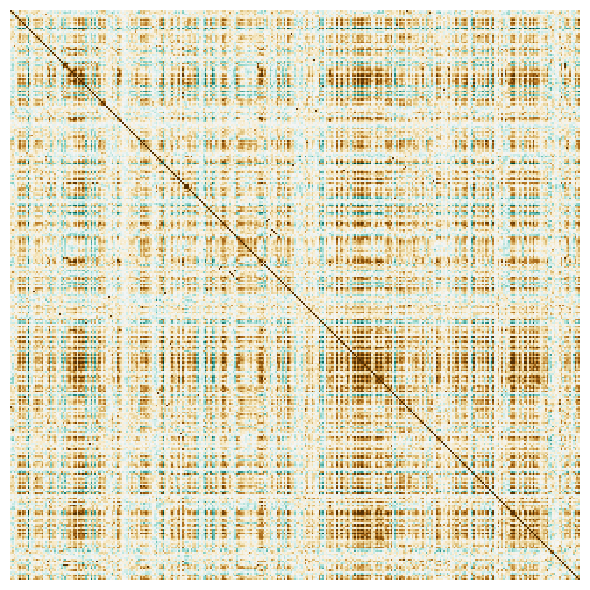

In [316]:
thres = 0.4
regulator_reordered_all = np.empty(0)
for cl in [21, 22, 99]:
    np.random.seed(100)
    genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
    genelist = set(genelist) & set(adata_de.obs.target_contrast_corrected.value_counts()[adata_de.obs.target_contrast_corrected.value_counts()==3].index)
    if cl!=22:
        regulator = list(set(genelist) - set(core_tcr_geneid))
    else:
        regulator = list(genelist)
    
    # Reorder regulator based on hierarchical clustering of regulators in main conditions
    # For each cluster, get regulator member list
    main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(corr_df_all.loc[regulator_main_condition, regulator_main_condition],
                                method='average', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    plt.close(clustermap.fig)
    if cl!=99:
        regulator_reordered = np.array(regulator)[xticklabel_indices][::-1]
    else:
        regulator_reordered = np.array(regulator)[xticklabel_indices]
    regulator_reordered_all = np.concatenate([regulator_reordered_all, regulator_reordered])

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered_all, target_names_rest)
regulator_rest = regulator_reordered_all[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered_all, target_names_stim8hr)
regulator_stim8hr = regulator_reordered_all[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered_all, target_names_stim48hr)
regulator_stim48hr = regulator_reordered_all[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

# Create figure with space for color bars
fig, ax = plt.subplots(figsize=(6, 6))#, constrained_layout=True)

# Create heatmap
sns.heatmap(corr_df_all.loc[regulator_rest, regulator_rest],
            vmin=-thres, vmax=thres, cmap='BrBG_r',
            cbar=False, xticklabels=False, yticklabels=False,
            square=True, ax=ax)

plt.tight_layout()
plt.savefig('./results/cluster21_22_99_rest.png', dpi=600)

130
11
184


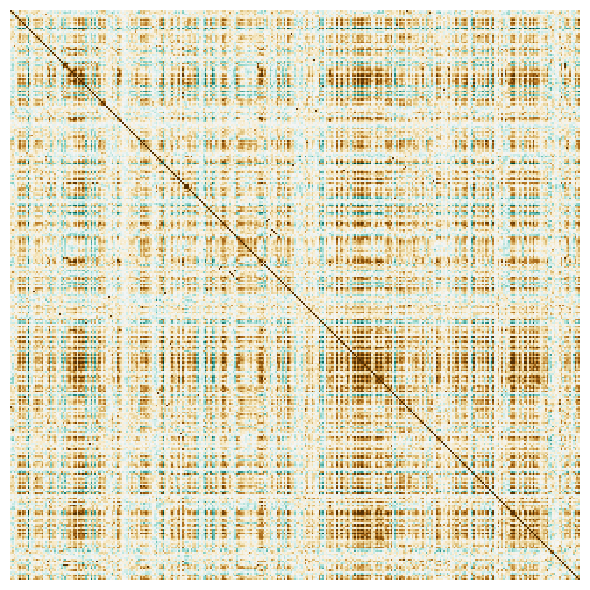

In [318]:
thres = 0.4
regulator_reordered_all = np.empty(0)
for cl in [21, 22, 99]:
    np.random.seed(100)
    genelist = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
    genelist = set(genelist) & set(adata_de.obs.target_contrast_corrected.value_counts()[adata_de.obs.target_contrast_corrected.value_counts()==3].index)
    if cl!=22:
        regulator = list(set(genelist) - set(core_tcr_geneid))
        print(len(regulator))
    else:
        regulator = list(genelist)
        print(len(regulator))
    
    # Reorder regulator based on hierarchical clustering of regulators in main conditions
    # For each cluster, get regulator member list
    main_condition = adata_final[adata_final.obs['hdbscan']==cl].obs['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(corr_df_all.loc[regulator_main_condition, regulator_main_condition],
                                method='average', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    plt.close(clustermap.fig)
    if cl!=99:
        regulator_reordered = np.array(regulator)[xticklabel_indices][::-1]
    else:
        regulator_reordered = np.array(regulator)[xticklabel_indices]
    regulator_reordered_all = np.concatenate([regulator_reordered_all, regulator_reordered])

target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered_all, target_names_rest)
regulator_rest = regulator_reordered_all[isin_mask]
regulator_rest = [item+'_Rest' for item in regulator_rest]
target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered_all, target_names_stim8hr)
regulator_stim8hr = regulator_reordered_all[isin_mask]
regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_corrected']
isin_mask = np.isin(regulator_reordered_all, target_names_stim48hr)
regulator_stim48hr = regulator_reordered_all[isin_mask]
regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])

# Create figure with space for color bars
fig, ax = plt.subplots(figsize=(6, 6))#, constrained_layout=True)

# Create heatmap
sns.heatmap(corr_df_all.loc[regulator_rest, regulator_rest],
            vmin=-thres, vmax=thres, cmap='BrBG_r',
            cbar=False, xticklabels=False, yticklabels=False,
            square=True, ax=ax)

plt.tight_layout()
#plt.savefig('./results/cluster21_22_99_rest.png', dpi=600)

In [292]:
np.where(np.array(genename_list)=='PPP3R1')

(array([65]),)

In [293]:
geneid = geneid_list[65]

In [294]:
sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 

In [295]:
sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
sample_measurements

array([0.41413061, 0.43755969])

In [304]:
cl = [21,22]
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if ((np.abs(sample_measurements[1])/np.abs(sample_measurements[0]))<1.5)&((np.abs(sample_measurements[0])/np.abs(sample_measurements[1])<1.5))\
        &((np.abs(sample_measurements[0])>0.3)|(np.abs(sample_measurements[1])>0.3)):
            temp_list.append(genename_list[i])
#print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)].target_name.tolist()

temp_list1 = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
print(set(temp_list1))

{'TLN1', 'CAMSAP1', 'CARD11', 'MALT1', 'PEX5', 'EIF4G2', 'ITK', 'PTPRC', 'VAV1', 'SPTLC2', 'CD28', 'XPR1', 'PLCG1', 'CD3E', 'EML2', 'CYB5R4', 'CD2', 'ZAP70', 'LAT', 'CARMIL2', 'CD3D', 'TBX22', 'RAC2', 'DDX60L', 'ABHD17A', 'USP22', 'HELT', 'CALCOCO2', 'ACTR2', 'ARPC2', 'KAT6A', 'LCP2', 'MBD2', 'ERCC6L2', 'SHOC2', 'FAM204A', 'COG6', 'NKAPD1', 'LCK', 'SENP1', 'UBIAD1', 'DNAJC8', 'ATXN7L3', 'CD247', 'ANKRD61', 'TMX1', 'CD3G', 'BCL10', 'CRIPT', 'RNF19B'}


In [305]:
cl = [99]
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if ((np.abs(sample_measurements[1])/np.abs(sample_measurements[0]))<1.5)&((np.abs(sample_measurements[0])/np.abs(sample_measurements[1])<1.5))\
        &((np.abs(sample_measurements[0])>0.3)|(np.abs(sample_measurements[1])>0.3)):
            temp_list.append(genename_list[i])
#print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)].target_name.tolist()

temp_list2 = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
print(set(temp_list2))

{'CLCC1', 'CAMSAP1', 'TLN1', 'TMEM140', 'MALT1', 'PEX5', 'NCAPG2', 'DOLPP1', 'PTPRC', 'ITK', 'DCAF5', 'AASDH', 'KIF14', 'CD28', 'PLCG1', 'CD3E', 'EML2', 'CYB5R4', 'CREBBP', 'SND1', 'CD2', 'ZAP70', 'LAT', 'CARMIL2', 'CD3D', 'TBX22', 'RAC2', 'HELT', 'CALCOCO2', 'KAT6A', 'LCP2', 'LETM2', 'SHOC2', 'COG6', 'NKAPD1', 'LCK', 'SENP1', 'BCL11B', 'UBIAD1', 'GNE', 'DNAJC8', 'PRKCQ', 'ATXN7L3', 'ELOB', 'CD247', 'ANKRD61', 'TMX1', 'CD3G', 'NFIX', 'PHF6', 'BCL10', 'VAV1', 'RNF19B'}


In [308]:
set(temp_list1) - set(temp_list2)

{'ABHD17A',
 'ACTR2',
 'ARPC2',
 'CARD11',
 'CRIPT',
 'DDX60L',
 'EIF4G2',
 'ERCC6L2',
 'FAM204A',
 'MBD2',
 'SPTLC2',
 'USP22',
 'XPR1'}

In [189]:
cl = [21,22,60,99]
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if ((np.abs(sample_measurements[1])/np.abs(sample_measurements[0]))<1.5):
            temp_list.append(genename_list[i])
print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)].target_name.tolist()

temp_list = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
print(set(temp_list))

{'SLC7A6', 'PPDPF', 'CAMSAP1', 'BCL11B', 'CARD11', 'CBLL1', 'BCAT2', 'COG5', 'C8orf82', 'TBX22', 'SLC3A2', 'RREB1', 'LCP2', 'FITM2', 'NCBP3', 'DTX4', 'ARID4B', 'TMED9', 'PLIN4', 'RNF19B', 'PLEK2', 'RBM33', 'FAM204A', 'PHF19', 'ANKRD61', 'USP22', 'DET1', 'MBD5', 'KIF16B', 'MED23', 'UHRF1', 'PGGT1B', 'KRCC1', 'NPHP4', 'KCTD21', 'CYB5R4', 'NABP1', 'DIS3L2', 'CREBBP', 'ATF7IP2', 'GPR15', 'ATL1', 'SCAF4', 'ARPC2', 'NKAPD1', 'CD3D', 'SACM1L', 'PARP14', 'CD3G', 'NDFIP2', 'TENT2', 'NFKBID', 'EIF4G2', 'MAP3K5', 'BCAP29', 'MTA3', 'TMEM140', 'ACTR2', 'IKZF1', 'CHURC1', 'SPTLC2', 'FZD6', 'RAC2', 'UBE2E2', 'FBRS', 'YIPF1', 'TLN1', 'PDIA3', 'ABHD17A', 'CARMIL2', 'PRKCQ', 'ITM2A', 'MEMO1', 'PCSK5', 'MAP3K1', 'COG6', 'PRAM1', 'DCAF5', 'SPATA33', 'INPP5D', 'PAK1', 'ATRX', 'TMX1', 'MTMR3', 'OST4', 'KIF14', 'ITK', 'KAT6A', 'USP7', 'GZMB', 'PEX5', 'ELOB', 'NFKBIL1', 'ENDOG', 'TASOR', 'CRTAP', 'VPS29', 'BRD9', 'THAP12', 'PLCG1', 'EDC3', 'TSC2', 'PTPRC', 'CCDC138', 'LCK', 'ZAP70', 'EML2', 'PPP1R10', 'CLCC1'

In [ ]:
cl = [21,22,60,99]
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if ((np.abs(sample_measurements[1])/np.abs(sample_measurements[0]))<1.5):
            temp_list.append(genename_list[i])
print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)].target_name.tolist()

temp_list = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
print(set(temp_list))

In [310]:
cl = [21,22]
cond = 'Stim8hr'
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if ((np.abs(sample_measurements[0])/np.abs(sample_measurements[1]))>1.8) | (sample_measurements[1]<0):
            temp_list.append(genename_list[i])
print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)&(de_by_guide['culture_condition']==cond)].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)&(donor_robustness_summary['condition']==cond)].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)&(de_by_guide['culture_condition']==cond)].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)&(donor_robustness_summary['condition']==cond)].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)&(de_by_guide['culture_condition']==cond)].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)&(donor_robustness_summary['condition']==cond)].target_name.tolist()

temp_list1 = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
#print(set(temp_list))

{'UBE2E2', 'BCAP29', 'RREB1', 'TTC7A', 'ARHGAP27', 'TSC1', 'ATP2A2', 'TMED9', 'UBL7', 'SRP9', 'YIPF1', 'TTF1', 'LRIG1', 'PDIA3', 'TSC2', 'COG5', 'AIRIM', 'ATP2A3', 'SLC7A6', 'CYB561D2', 'WAS', 'PLIN4', 'ARID4B', 'DIPK1A', 'WAPL', 'KCTD21', 'MTA3', 'PLEK2', 'MBD2', 'DZIP1', 'SACM1L', 'FLVCR2', 'RAB19', 'BCAT2', 'DTX4', 'FZD6', 'SNAP29', 'HEXD', 'SLC3A2', 'MBD5', 'BLOC1S4', 'KIF16B', 'APPL2', 'GPRASP1', 'UHRF1', 'CHURC1', 'SOS2', 'PGGT1B', 'FITM2', 'COP1', 'EFR3A', 'VPS35', 'MCFD2', 'ORAI1', 'SYK', 'SPATA33', 'C8orf82', 'ZNF790', 'CDIPT', 'NCBP3', 'MEMO1'}


In [311]:
cl = 99
cond = 'Stim48hr'
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if ((np.abs(sample_measurements[1])/np.abs(sample_measurements[0]))>1.8) | (sample_measurements[0]<0):
            temp_list.append(genename_list[i])
print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)&(de_by_guide['culture_condition']==cond)].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)&(donor_robustness_summary['condition']==cond)].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)&(de_by_guide['culture_condition']==cond)].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)&(donor_robustness_summary['condition']==cond)].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)&(de_by_guide['culture_condition']==cond)].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)&(donor_robustness_summary['condition']==cond)].target_name.tolist()

temp_list2 = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
#print(set(temp_list))

{'ERCC4', 'ZRANB2', 'TFAP4', 'SS18L2', 'APEX1', 'SAXO5', 'PIBF1', 'C11orf54', 'OSR1', 'PRKDC', 'LSS', 'SMARCD1', 'CEP135', 'IMPDH2', 'FMR1', 'FIGNL1', 'MAF', 'ICE2', 'METTL23', 'SZRD1', 'NUP37', 'C1D', 'CUL4A', 'KMT2E', 'FBXW7', 'STAT5A', 'NCAPD3', 'SKA2', 'CLDN7', 'MTMR10', 'RAB1A', 'WNK1', 'VEZT', 'IKBKB', 'YIPF3', 'NUP188', 'IL12RB2', 'TP73', 'PGAP2', 'SRSF11', 'EWSR1', 'JUNB', 'L2HGDH', 'CEP89', 'ZNF837', 'ZNF703', 'SLC16A1', 'GALNT6', 'FOXO1', 'PCYT2', 'TMEM263', 'PKN3', 'OTUB1', 'RNASEH2A', 'TBX21', 'MTX2', 'PARP3', 'SET', 'ANKRD49', 'DOT1L', 'IRF4', 'SNAP23', 'PHF23', 'FCHO1', 'GPI', 'CCN1', 'DNAAF5', 'ADAT2', 'RAD51B', 'BICDL1', 'TPGS2', 'ZC3H10', 'SLC9A5', 'GPALPP1', 'PDCD5', 'RPS6KA1', 'NUP42', 'UBR4', 'ATP1B3', 'N6AMT1', 'FDX1', 'CCDC134', 'LSM12', 'GDAP2', 'TNRC6A', 'KGD4', 'DCAF4', 'ERCC1', 'SRR', 'FANCL', 'MYO9A', 'HAPSTR1', 'GSS', 'SIK3', 'CTPS1', 'GPS2', 'RIDA', 'TBCA', 'EIF1', 'ADAT3', 'ST8SIA1', 'MEN1', 'SOCS4', 'PRKAR1B', 'COLGALT1', 'RNF8', 'BRAT1', 'NADK2', 'PYGM'}

In [313]:
set(temp_list2)-set(temp_list1)

{'ADAT2',
 'ADAT3',
 'ANKRD49',
 'APEX1',
 'ATP1B3',
 'BRAT1',
 'C11orf54',
 'C1D',
 'CCDC134',
 'CEP135',
 'CEP89',
 'CLDN7',
 'COLGALT1',
 'CTPS1',
 'DCAF4',
 'DOT1L',
 'EIF1',
 'ERCC1',
 'ERCC4',
 'EWSR1',
 'FBXW7',
 'FCHO1',
 'FIGNL1',
 'FMR1',
 'FOXO1',
 'GALNT6',
 'GDAP2',
 'GPI',
 'GSS',
 'IMPDH2',
 'JUNB',
 'KMT2E',
 'L2HGDH',
 'LSM12',
 'MAF',
 'MEN1',
 'METTL23',
 'MTMR10',
 'MTX2',
 'N6AMT1',
 'NUP188',
 'NUP37',
 'OSR1',
 'OTUB1',
 'PCYT2',
 'PDCD5',
 'PGAP2',
 'PHF23',
 'PIBF1',
 'PRKAR1B',
 'PRKDC',
 'PYGM',
 'RAD51B',
 'RIDA',
 'RNF8',
 'RPS6KA1',
 'SIK3',
 'SKA2',
 'SLC16A1',
 'SMARCD1',
 'SNAP23',
 'SOCS4',
 'SS18L2',
 'STAT5A',
 'SZRD1',
 'TBCA',
 'TBX21',
 'TFAP4',
 'TMEM263',
 'TNRC6A',
 'TPGS2',
 'UBR4',
 'VEZT',
 'WNK1',
 'YIPF3',
 'ZC3H10',
 'ZNF837'}

In [141]:
cl = 99
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if (sample_measurements[1] - sample_measurements[0])>0.2:
            temp_list.append(genename_list[i])
print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)&(de_by_guide['culture_condition']=='Stim4hr')].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)&(donor_robustness_summary['condition']=='Stim48hr')].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)&(de_by_guide['culture_condition']=='Stim48hr')].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)&(donor_robustness_summary['condition']=='Stim48hr')].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)&(de_by_guide['culture_condition']=='Stim48hr')].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)&(donor_robustness_summary['condition']=='Stim48hr')].target_name.tolist()

temp_list = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
print(set(temp_list))

{'TPGS2', 'C11orf54', 'IRF4', 'RIDA', 'PARP3', 'TNRC6A', 'ADAT3', 'SZRD1', 'PIBF1', 'FMR1', 'TP73', 'SS18L2', 'SAXO5', 'EWSR1', 'RAB1A', 'CUL4A', 'SNAP23', 'PRKAR1B', 'DNAAF5', 'CCN1', 'CCDC134', 'ATP1B3', 'SMARCD1', 'C1D', 'RPS6KA1', 'BICDL1', 'KMT2E', 'ZRANB2', 'YIPF3', 'L2HGDH', 'MYO9A', 'METTL23', 'FIGNL1', 'DOT1L', 'GPALPP1', 'PGAP2', 'CEP89', 'SET', 'IMPDH2', 'LSS', 'ANKRD49', 'RNF8', 'BRAT1', 'ERCC4', 'FCHO1', 'ICE2', 'PDCD5', 'NUP42', 'VEZT', 'COLGALT1', 'PYGM', 'NADK2', 'HAPSTR1', 'FBXW7', 'SLC9A5', 'IKBKB', 'EIF1', 'SRR', 'TBCA', 'FOXO1', 'ADAT2', 'ZNF837', 'SKA2', 'GDAP2', 'PRKDC', 'KGD4', 'GPS2', 'OSR1', 'MTX2', 'GSS', 'APEX1', 'PKN3', 'MTMR10', 'MAF', 'GALNT6', 'TBX21', 'SIK3', 'GPI', 'SOCS4', 'FDX1', 'ERCC1', 'SLC16A1', 'RAD51B', 'CTPS1', 'UBR4', 'RNASEH2A', 'DCAF4', 'STAT5A'}
{'TPGS2', 'ATP1B3', 'C11orf54', 'RIDA', 'FCHO1', 'OSR1', 'SMARCD1', 'C1D', 'GSS', 'MTX2', 'RPS6KA1', 'APEX1', 'PDCD5', 'KMT2E', 'YIPF3', 'TNRC6A', 'VEZT', 'COLGALT1', 'ADAT3', 'PYGM', 'MTMR10', 'L2H

In [108]:
cl = [21,60]
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if (sample_measurements[0] - sample_measurements[1])>0.2:
            temp_list.append(genename_list[i])
print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)&(de_by_guide['culture_condition']=='Stim8hr')].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)&(donor_robustness_summary['condition']=='Stim8hr')].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)&(de_by_guide['culture_condition']=='Stim8hr')].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)&(donor_robustness_summary['condition']=='Stim8hr')].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)&(de_by_guide['culture_condition']=='Stim8hr')].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)&(donor_robustness_summary['condition']=='Stim8hr')].target_name.tolist()

temp_list = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
print(set(temp_list))

{'SLC7A6', 'COG5', 'SLC3A2', 'RREB1', 'FITM2', 'NCBP3', 'DTX4', 'TMED9', 'ARID4B', 'PLIN4', 'PLEK2', 'RBM33', 'DET1', 'MBD5', 'KIF16B', 'UHRF1', 'PGGT1B', 'KRCC1', 'KCTD21', 'DIS3L2', 'ATL1', 'SACM1L', 'TENT2', 'NDFIP2', 'BCAP29', 'MTA3', 'CHURC1', 'FZD6', 'UBE2E2', 'THAP12', 'ITM2A', 'MEMO1', 'PCSK5', 'MAP3K1', 'SPATA33', 'PAK1', 'MTMR3', 'GZMB', 'ENDOG', 'CRTAP', 'CCDC138', 'LCK', 'ARHGAP27', 'GPRASP1', 'WAPL', 'SRP9', 'ATG12', 'SLC5A6', 'MBD2', 'HACD4', 'EIF1AX', 'ZNF790', 'PTPN1', 'TTC7A', 'SNAP29', 'STOM', 'COP1', 'ANKAR', 'APPL2', 'EFR3A', 'HLA-DOA', 'CRYZL1', 'DIPK1A', 'LRP2BP', 'RAB19', 'SCRN3', 'HEXD', 'SPTBN1', 'AP1S2', 'SLC17A5', 'SYK', 'TTF1', 'SOS2', 'MCFD2', 'LRBA', 'VPS35', 'UBL7', 'ORAI1', 'CYB561D2', 'TIMM10', 'ATP2A2', 'TSC1', 'MMP9', 'CALCOCO2', 'RWDD2B', 'LRIG1', 'AIRIM', 'WAS', 'ATP2A3', 'FLVCR2', 'ULK4', 'NATD1'}
{'SLC7A6', 'WAPL', 'FZD6', 'SRP9', 'ATG12', 'SYK', 'SLC3A2', 'MAP3K1', 'RREB1', 'TMED9', 'ARID4B', 'PLIN4', 'MBD2', 'HACD4', 'TTC7A', 'VPS35', 'SNAP29', 

In [321]:
de_by_guide[de_by_guide.target=='PGGT1B']

,target,correlation,correlation_ceiling,n_signif_union,n_signif_1,n_signif_2,culture_condition
1648,PGGT1B,0.624995,0.803533,2264,1764,1160,Stim8hr


In [320]:
donor_robustness_summary[donor_robustness_summary.target_name=='PGGT1B']

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
956,PGGT1B,0.424183,0.313408,ENSG00000164219,Rest,81.0,145,30,175,-3.887083,True,26.457280,False,>10 DE genes,on-target KD
1037,PGGT1B,0.558055,0.429229,ENSG00000164219,Stim8hr,102.0,2172,842,3014,-4.217847,True,35.003856,False,>10 DE genes,on-target KD


In [319]:
de_summary_stats[de_summary_stats.target_name=='PGGT1B']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
1631,ENSG00000164219,PGGT1B,Stim48hr,49.0,171,31,202,-2.088341,False,28.581663,False,>10 DE genes,no on-target KD,ENSG00000164219,ENSG00000164219_Stim48hr,PGGT1B
20662,ENSG00000164219,PGGT1B,Stim8hr,102.0,2172,842,3014,-4.217847,True,35.003856,False,>10 DE genes,on-target KD,ENSG00000164219,ENSG00000164219_Stim8hr,PGGT1B
33616,ENSG00000164219,PGGT1B,Rest,81.0,145,30,175,-3.887083,True,26.457280,False,>10 DE genes,on-target KD,ENSG00000164219,ENSG00000164219_Rest,PGGT1B


In [122]:
cl = [21]
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if (sample_measurements[0] - sample_measurements[1])>0.2:
            temp_list.append(genename_list[i])
print(set(temp_list))

temp1 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.2)&(de_by_guide['culture_condition']=='Stim8hr')].target.tolist()
temp2 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']<0)&(donor_robustness_summary['condition']=='Stim8hr')].target_name.tolist()

temp3 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']<0)&(de_by_guide['culture_condition']=='Stim8hr')].target.tolist()
temp4 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.2)&(donor_robustness_summary['condition']=='Stim8hr')].target_name.tolist()

temp5 = de_by_guide[(de_by_guide.target.isin(temp_list))&(de_by_guide['correlation']>0.1)&(de_by_guide['culture_condition']=='Stim8hr')].target.tolist()
temp6 = donor_robustness_summary[(donor_robustness_summary.target_name.isin(temp_list))&(donor_robustness_summary['donor_correlation_min']>0.1)&(donor_robustness_summary['condition']=='Stim8hr')].target_name.tolist()

temp_list = (set(temp1)-set(temp2))|(set(temp4)-set(temp3))|(set(temp5)&set(temp6))
print(set(temp_list))

{'SLC7A6', 'BCAP29', 'RAB19', 'HEXD', 'ARHGAP27', 'GPRASP1', 'WAPL', 'CHURC1', 'COG5', 'FZD6', 'UBE2E2', 'SRP9', 'THAP12', 'SYK', 'TTF1', 'SOS2', 'SLC3A2', 'MCFD2', 'LRBA', 'MEMO1', 'FITM2', 'NCBP3', 'DTX4', 'TMED9', 'ARID4B', 'PLIN4', 'SPATA33', 'RREB1', 'MBD2', 'HACD4', 'PLEK2', 'ZNF790', 'TTC7A', 'VPS35', 'SNAP29', 'UBL7', 'RBM33', 'ORAI1', 'MTA3', 'MBD5', 'KIF16B', 'UHRF1', 'PGGT1B', 'CYB561D2', 'KCTD21', 'ATP2A2', 'COP1', 'TSC1', 'APPL2', 'CALCOCO2', 'EFR3A', 'LRIG1', 'AIRIM', 'SACM1L', 'WAS', 'NDFIP2', 'ATP2A3', 'FLVCR2', 'DIPK1A', 'LCK', 'NATD1'}
{'SLC7A6', 'WAPL', 'FZD6', 'SRP9', 'SYK', 'SLC3A2', 'RREB1', 'TMED9', 'ARID4B', 'PLIN4', 'MBD2', 'HACD4', 'TTC7A', 'VPS35', 'SNAP29', 'ORAI1', 'MBD5', 'PGGT1B', 'UHRF1', 'CYB561D2', 'KCTD21', 'ATP2A2', 'COP1', 'TSC1', 'APPL2', 'CALCOCO2', 'EFR3A', 'LRIG1', 'WAS', 'NDFIP2', 'ATP2A3', 'LCK'}


In [9]:
cl = [21,60,99]
geneid_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_corrected.unique().tolist()
genename_list = adata_final[adata_final.obs.hdbscan.isin(cl)].obs.target_contrast_gene_name_corrected.unique().tolist()
temp_list = []
for i, geneid in enumerate(geneid_list):
    if (geneid+'_Stim8hr' in corr_df_all.index) & (geneid+'_Stim48hr' in corr_df_all.index):
        sample_measurements = np.array([corr_df_all.loc[geneid+'_Stim8hr', core_tcr_geneid_stim8hr].mean(),
                                        corr_df_all.loc[geneid+'_Stim48hr', core_tcr_geneid_stim48hr].mean()]) 
        if (((sample_measurements[1] - sample_measurements[0])<=0.2) & ((sample_measurements[0] - sample_measurements[1])<=0.2) & (np.min(sample_measurements)>=0.3)) | (np.min(sample_measurements)>=0.45):
            temp_list.append(genename_list[i])
print(set(temp_list))

{'TMEM140', 'ZAP70', 'EML2', 'CAMSAP1', 'CARD11', 'CLCC1', 'VAV1', 'ACTR2', 'LRP5', 'IKZF1', 'HELT', 'SHOC2', 'RAC2', 'NCAPG2', 'MALT1', 'CARMIL2', 'TBX22', 'TLN1', 'ABHD17A', 'DNAJC8', 'NFIX', 'LRBA', 'COG6', 'LCP2', 'DDX60L', 'CD28', 'DOLPP1', 'RNF19B', 'CD3E', 'CD2', 'FAM204A', 'TMX1', 'ANKRD61', 'CD247', 'KIF14', 'DCAF11', 'ERCC6L2', 'ITK', 'NPHP4', 'PEX5', 'PPP3R1', 'CYB5R4', 'TASOR', 'BCL10', 'LAT', 'CREBBP', 'ATF7IP2', 'CNOT6L', 'CALCOCO2', 'HS3ST3B1', 'ARPC2', 'PLCG1', 'NKAPD1', 'CD3D', 'UBIAD1', 'PARP14', 'CD3G', 'ZSCAN23', 'PTPRC', 'LCK'}


In [101]:
temp_list1 = temp_list

In [99]:
temp_list2 = temp_list

In [102]:
print(set(temp_list1 + temp_list2))

{'CD2', 'KIF14', 'CLCC1', 'ABHD17A', 'ARPC2', 'TLN1', 'RAC2', 'NCAPG2', 'CREBBP', 'BCL10', 'RNF19B', 'ZAP70', 'HELT', 'CD3G', 'VAV1', 'ITK', 'DNAJC8', 'LAT', 'ZSCAN23', 'CD247', 'NKAPD1', 'DCAF11', 'PTPRC', 'PEX5', 'TMEM140', 'ACTR2', 'LRP5', 'EML2', 'COG6', 'NFIX', 'DDX60L', 'ERCC6L2', 'LCP2', 'HS3ST3B1', 'CYB5R4', 'LCK', 'CARD11', 'TMX1', 'PPP3R1', 'CARMIL2', 'MALT1', 'TASOR', 'PLCG1', 'LRBA', 'CALCOCO2', 'CD3D', 'DOLPP1', 'CNOT6L', 'IKZF1', 'CD3E', 'TBX22', 'FAM204A', 'CAMSAP1', 'SHOC2', 'ANKRD61', 'CD28', 'UBIAD1'}


In [ ]:
'KIF14', 'CLCC1', 'ABHD17A', 'ARPC2', 'NCAPG2', 'CREBBP', 'RNF19B', 'HELT', 'DNAJC8', 'ZSCAN23', 'NKAPD1', 'DCAF11', 'PEX5', 'TMEM140', 'ACTR2', 'LRP5', 'EML2', 'COG6', 'NFIX', 'DDX60L', 'ERCC6L2', 'HS3ST3B1', 'CYB5R4', 'TMX1', 'TASOR', 'LRBA', 'CALCOCO2',  'DOLPP1', 'CNOT6L', 'IKZF1', 'TBX22', 'FAM204A', 'CAMSAP1', 'SHOC2', 'ANKRD61', 'UBIAD1'

In [66]:
cl = 60
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
test60 = corr_df_all.loc[[item+'_Stim8hr' for item in geneid_list], core_tcr_geneid_stim8hr].mean(1).tolist()
cl = 21
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
test21 = corr_df_all.loc[[item+'_Stim8hr' for item in geneid_list], core_tcr_geneid_stim8hr].mean(1).tolist()
cl = 99
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
test99 = corr_df_all.loc[[item+'_Stim48hr' for item in geneid_list], core_tcr_geneid_stim48hr].mean(1).tolist()

In [69]:
cl = 77
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
test77 = corr_df_all.loc[[item+'_Stim48hr' for item in geneid_list], core_tcr_geneid_stim48hr].mean(1).tolist()

In [8]:
np.sum(np.array(test21)>0.6)

28

In [48]:
cl = 60
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = np.array(adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist())
test60 = np.array(corr_df_all.loc[[item+'_Stim8hr' for item in geneid_list], core_tcr_geneid_stim8hr].mean(1))
list60 = genename_list[test60>0.3]

In [49]:
cl = 21
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = np.array(adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist())
test21 = np.array(corr_df_all.loc[[item+'_Stim8hr' for item in geneid_list], core_tcr_geneid_stim8hr].mean(1))
list21 = genename_list[test21>0.45]

In [50]:
cl = 99
geneid_list = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
genename_list = np.array(adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique().tolist())
test99 = np.array(corr_df_all.loc[[item+'_Stim48hr' for item in geneid_list], core_tcr_geneid_stim48hr].mean(1))
list99 = genename_list[test99>0.3]

In [53]:
set(list99) & set(list21)

{'BCL10',
 'CALCOCO2',
 'CAMSAP1',
 'CARMIL2',
 'CD28',
 'COG6',
 'HELT',
 'ITK',
 'LCK',
 'MALT1',
 'NDFIP2',
 'PEX5',
 'PTPRC',
 'RNF19B',
 'SHOC2',
 'TMX1',
 'UBIAD1'}

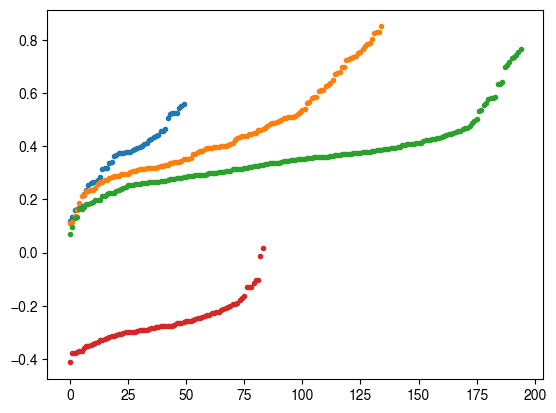

In [70]:
plt.plot(np.sort(test60), '.')
plt.plot(np.sort(test21), '.')
plt.plot(np.sort(test99), '.')
plt.plot(np.sort(test77), '.')

In [11]:
df_downstream = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)

In [13]:
top_perc = 0.025

df_downstream_neg = pd.DataFrame()
for cl in adata_final.obs.hdbscan.unique():
    rank_cutoff = len(df_downstream[df_downstream.hdbscan_cluster==cl])*top_perc
    df_temp = df_downstream[(df_downstream.hdbscan_cluster==cl)&(df_downstream['zscore_rank_negative_regulation']<rank_cutoff)].copy()
    df_downstream_neg = pd.concat([df_downstream_neg, df_temp])

df_downstream_pos = pd.DataFrame()
for cl in adata_final.obs.hdbscan.unique():
    rank_cutoff = len(df_downstream[df_downstream.hdbscan_cluster==cl])*top_perc
    df_temp = df_downstream[(df_downstream.hdbscan_cluster==cl)&(df_downstream['zscore_rank_positive_regulation']<rank_cutoff)].copy()
    df_downstream_pos = pd.concat([df_downstream_pos, df_temp])

In [330]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='LRBA'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000198589_Stim8hr,LRBA,Stim8hr,ENSG00000198589,216,376.0,ENSG00000198589,LRBA,21
ENSG00000198589_Stim48hr,LRBA,Stim48hr,ENSG00000198589,587,351.0,ENSG00000198589,LRBA,93


In [331]:
de_by_guide[de_by_guide.target=='LRBA']

,target,correlation,correlation_ceiling,n_signif_union,n_signif_1,n_signif_2,culture_condition
1464,LRBA,-0.103421,NaN,4610,4610,1,Stim8hr
2512,LRBA,-0.119075,NaN,2044,1,2044,Stim48hr


In [277]:
genelist = ['SYK', 'APPL2', 'FZD6', 'ORAI1', 'ATP2A2', 'ATP2A3',
            'SLC3A2', 'SLC7A6', 'PLIN4', 'VPS35', 'SNAP29', 'TMED9',
            'TTC7A', 'BLOC1S4', 'EFR3A', 'WAS', 'ARID4B', 'MBD2', 'UHRF1',
            'WAPL', 'PGGT1B', 'KCTD21', 'COP1', 'WAPL']

In [328]:
genelist = ['CLCC1', 'CAMSAP1', 'PEX5', 'NCAPG2', 'DOLPP1', 'SPTLC2', 'XPR1', 'CYB5R4', 'SND1', 'TBX22', 'DDX60L',
            'USP22', 'HELT', 'ACTR2', 'ARPC2', 'KAT6A', 'MBD2', 'SHOC2', 'COG6', 'SENP1', 'BCL11B', 'GNE', 'DNAJC8', 'ELOB'
            'NFIX', 'PHF6', 'FAM204A', 'CRIPT', 'RNF19B', 'TMEM140', 'EIF4G2', 'DCAF5', 'AASDH', 'KIF14', 'EML2', 'CREBBP', 'MBD5',
            'ABHD17A', 'CALCOCO2', 'LETM2', 'ERCC6L2', 'NKAPD1', 'UBIAD1', 'ATXN7L3', 'ANKRD61', 'TMX1', 'C1D', 'ATP1B3', 'YIPF3', 'VEZT']

In [329]:
de_summary_stats[de_summary_stats.target_name.isin(genelist)].sort_values(by='target_name')

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
33963,ENSG00000157426,AASDH,Rest,651.0,53,98,151,-7.308273,True,12.146344,False,>10 DE genes,on-target KD,ENSG00000157426,ENSG00000157426_Rest,AASDH
32136,ENSG00000157426,AASDH,Stim48hr,515.0,52,49,101,-9.821892,True,24.799402,False,>10 DE genes,on-target KD,ENSG00000157426,ENSG00000157426_Stim48hr,AASDH
21315,ENSG00000157426,AASDH,Stim8hr,577.0,0,1,1,-8.384237,True,15.752295,False,1 DE gene,on-target KD,ENSG00000157426,ENSG00000157426_Stim8hr,AASDH
19605,ENSG00000129968,ABHD17A,Stim48hr,439.0,40,27,67,0.000000,False,NaN,False,>10 DE genes,no on-target KD,ENSG00000129968,ENSG00000129968_Stim48hr,ABHD17A
23255,ENSG00000129968,ABHD17A,Rest,385.0,1,1,2,0.000000,False,NaN,False,2-10 DE genes,no on-target KD,ENSG00000129968,ENSG00000129968_Rest,ABHD17A
20108,ENSG00000129968,ABHD17A,Stim8hr,441.0,101,22,123,0.000000,False,NaN,False,>10 DE genes,no on-target KD,ENSG00000129968,ENSG00000129968_Stim8hr,ABHD17A
4419,ENSG00000138071,ACTR2,Stim8hr,255.0,399,184,583,-18.894150,True,157.875674,False,>10 DE genes,on-target KD,ENSG00000138071,ENSG00000138071_Stim8hr,ACTR2
3625,ENSG00000138071,ACTR2,Stim48hr,164.0,662,387,1049,-17.546191,True,281.461728,False,>10 DE genes,on-target KD,ENSG00000138071,ENSG00000138071_Stim48hr,ACTR2
18507,ENSG00000138071,ACTR2,Rest,241.0,56,21,77,-21.039374,True,215.422922,False,>10 DE genes,on-target KD,ENSG00000138071,ENSG00000138071_Rest,ACTR2
28366,ENSG00000157999,ANKRD61,Rest,930.0,0,1,1,-0.120201,False,0.167902,False,1 DE gene,no on-target KD,ENSG00000157999,ENSG00000157999_Rest,ANKRD61


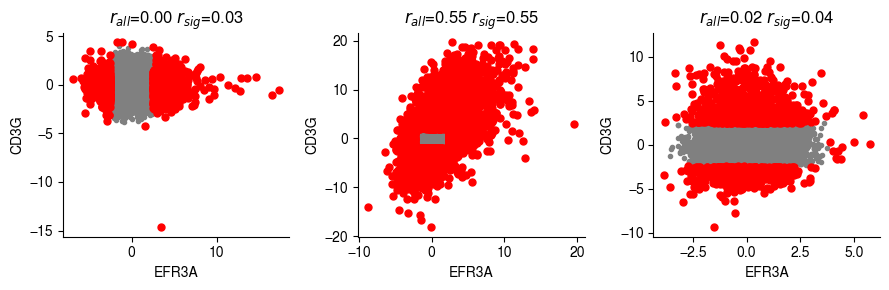

In [67]:
genelist =['EFR3A', 'CD3G']
fig, ax = plt.subplots(1,3,figsize=(9,3))
for i, cond in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
    cond_mask = adata_de.obs['culture_condition']==cond
    target_gene_mask = ~adata_de.var['gene_name'].isin(genelist)
    gene1_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['zscore'][0].copy()
    gene1_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['adj_p_value'][0].copy()
    gene2_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['zscore'][0].copy()
    gene2_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['adj_p_value'][0].copy()
    sig_mask = (gene1_padj<0.1)|(gene2_padj<0.1)
    ax[i].plot(gene1_zscore[~sig_mask], gene2_zscore[~sig_mask], '.', color='gray')
    ax[i].plot(gene1_zscore[sig_mask], gene2_zscore[sig_mask], '.', color='red', markersize=10)
    ax[i].set_xlabel(genelist[0])
    ax[i].set_ylabel(genelist[1])
    result_all = pearsonr(gene1_zscore, gene2_zscore)
    result_sig = pearsonr(gene1_zscore[sig_mask], gene2_zscore[sig_mask])
    ax[i].set_title(r'$r_{all}$='+f'{result_all.statistic:.2f} '+r'$r_{sig}$='+f'{result_sig.statistic:.2f}')
sns.despine()
plt.tight_layout()

In [69]:
genelist = ['ATP2A2', 'ATP2A3', 'SLC7A6', 'ORAI1', 'MAP3K1', 'SYK', 'SLC3A2', 'VPS35', 'WAS',
           'KIF16B', 'SNAP29', 'APPL2', 'EFR3A', 'LRBA', 'SACM1L', 'RWDD2B']
#pb[pb.obs.perturbed_gene_name_corrected.isin([genelist[6]])].obs.sort_values(by='culture_condition')

In [71]:
de_by_guide[de_by_guide.target.isin(genelist)].sort_values(by='target')

,target,correlation,correlation_ceiling,n_signif_union,n_signif_1,n_signif_2,culture_condition
997,APPL2,0.160336,NaN,2405,2404,1,Stim8hr
53,ATP2A2,0.756076,0.867583,2677,1788,1832,Rest
2138,ATP2A2,0.627729,0.835744,964,606,572,Stim48hr
1022,ATP2A2,0.649677,0.844653,2737,1883,1651,Stim8hr
1023,ATP2A3,0.995983,0.970880,3,1,3,Stim8hr
107,CCDC138,0.551767,NaN,55,55,1,Rest
1083,CCDC138,-0.392109,NaN,916,916,1,Stim8hr
148,COG5,0.077396,0.687440,309,185,133,Rest
1134,COG5,0.206652,0.659759,205,25,183,Stim8hr
1410,ITM2A,-0.063817,0.506290,220,1,220,Stim8hr


In [64]:
donor_robustness_summary[donor_robustness_summary.target_name.isin(genelist)].sort_values(by='target_name')

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
64,APPL2,0.416045,0.388634,ENSG00000136044,Stim8hr,769.0,407,53,460,-10.020330,True,42.342408,False,>10 DE genes,on-target KD
87,ATP2A2,0.659839,0.639296,ENSG00000174437,Rest,268.0,2361,1158,3519,-10.057253,True,66.024009,False,>10 DE genes,on-target KD
88,ATP2A2,0.533306,0.502220,ENSG00000174437,Stim48hr,107.0,1007,559,1566,-10.141807,True,128.153627,False,>10 DE genes,on-target KD
100,ATP2A2,0.562197,0.521922,ENSG00000174437,Stim8hr,248.0,2255,1005,3260,-15.645571,True,169.551562,False,>10 DE genes,on-target KD
101,ATP2A3,0.629073,0.478625,ENSG00000074370,Stim8hr,315.0,52,28,80,-8.800642,True,33.454727,False,>10 DE genes,on-target KD
172,CCDC138,0.121984,0.081780,ENSG00000163006,Rest,889.0,158,20,178,-11.149569,True,15.751711,False,>10 DE genes,on-target KD
194,CCDC138,-0.007962,-0.078198,ENSG00000163006,Stim8hr,888.0,785,177,962,-14.676485,True,29.433517,False,>10 DE genes,on-target KD
239,COG5,0.032387,-0.000258,ENSG00000164597,Rest,153.0,561,219,780,-4.888833,True,19.405340,True,>10 DE genes,on-target KD
273,COG5,0.021933,-0.011518,ENSG00000164597,Stim8hr,152.0,437,143,580,-5.714608,True,25.989455,True,>10 DE genes,on-target KD
370,EFR3A,0.255328,0.056049,ENSG00000132294,Rest,74.0,671,512,1183,-8.834976,True,97.474820,False,>10 DE genes,on-target KD


In [65]:
de_summary_stats[de_summary_stats.target_name.isin(genelist)].sort_values('target_name')

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
22800,ENSG00000136044,APPL2,Stim8hr,769.0,407,53,460,-10.020330,True,42.342408,False,>10 DE genes,on-target KD,ENSG00000136044,ENSG00000136044_Stim8hr,APPL2
4518,ENSG00000136044,APPL2,Stim48hr,1398.0,8,1,9,-12.222761,True,34.227203,False,2-10 DE genes,on-target KD,ENSG00000136044,ENSG00000136044_Stim48hr,APPL2
12056,ENSG00000136044,APPL2,Rest,1419.0,0,2,2,-11.581751,True,28.022758,False,2-10 DE genes,on-target KD,ENSG00000136044,ENSG00000136044_Rest,APPL2
26126,ENSG00000174437,ATP2A2,Rest,268.0,2361,1158,3519,-10.057253,True,66.024009,False,>10 DE genes,on-target KD,ENSG00000174437,ENSG00000174437_Rest,ATP2A2
28705,ENSG00000174437,ATP2A2,Stim8hr,248.0,2255,1005,3260,-15.645571,True,169.551562,False,>10 DE genes,on-target KD,ENSG00000174437,ENSG00000174437_Stim8hr,ATP2A2
26424,ENSG00000174437,ATP2A2,Stim48hr,107.0,1007,559,1566,-10.141807,True,128.153627,False,>10 DE genes,on-target KD,ENSG00000174437,ENSG00000174437_Stim48hr,ATP2A2
18892,ENSG00000074370,ATP2A3,Stim48hr,416.0,3,2,5,-16.250395,True,84.218843,False,2-10 DE genes,on-target KD,ENSG00000074370,ENSG00000074370_Stim48hr,ATP2A3
7893,ENSG00000074370,ATP2A3,Stim8hr,315.0,52,28,80,-8.800642,True,33.454727,False,>10 DE genes,on-target KD,ENSG00000074370,ENSG00000074370_Stim8hr,ATP2A3
27093,ENSG00000074370,ATP2A3,Rest,336.0,3,5,8,-20.094764,True,150.134430,False,2-10 DE genes,on-target KD,ENSG00000074370,ENSG00000074370_Rest,ATP2A3
9919,ENSG00000163006,CCDC138,Rest,889.0,158,20,178,-11.149569,True,15.751711,False,>10 DE genes,on-target KD,ENSG00000163006,ENSG00000163006_Rest,CCDC138


,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
0,ENSG00000012963,UBR7,Stim8hr,491.0,0,2,2,-12.952742,True,43.169196,True,2-10 DE genes,on-target KD,ENSG00000012963,ENSG00000012963_Stim8hr,UBR7
1,ENSG00000017260,ATP2C1,Stim8hr,469.0,0,1,1,-16.307246,True,102.399025,False,1 DE gene,on-target KD,ENSG00000017260,ENSG00000017260_Stim8hr,ATP2C1
2,ENSG00000067606,PRKCZ,Stim8hr,427.0,1,1,2,-1.658755,False,0.965897,False,2-10 DE genes,no on-target KD,ENSG00000067606,ENSG00000067606_Stim8hr,PRKCZ
3,ENSG00000092929,UNC13D,Stim8hr,830.0,0,2,2,-19.259466,True,60.904483,False,2-10 DE genes,on-target KD,ENSG00000092929,ENSG00000092929_Stim8hr,UNC13D
4,ENSG00000100504,PYGL,Stim8hr,414.0,1,0,1,0.000000,False,NaN,False,1 DE gene,no on-target KD,ENSG00000100504,ENSG00000100504_Stim8hr,PYGL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33981,ENSG00000198342,ZNF442,Rest,324.0,0,0,0,0.000000,False,NaN,False,no effect,no on-target KD,ENSG00000198342,ENSG00000198342_Rest,ZNF442
33982,ENSG00000205572,SERF1B,Rest,44.0,7,24,31,0.000000,False,NaN,False,>10 DE genes,no on-target KD,ENSG00000205572,ENSG00000205572_Rest,SERF1B
33983,ENSG00000221890,NPTXR,Rest,293.0,0,3,3,-1.027171,False,0.798092,False,2-10 DE genes,no on-target KD,ENSG00000221890,ENSG00000221890_Rest,NPTXR
33984,ENSG00000236320,SLFN14,Rest,848.0,0,0,0,0.000000,False,NaN,False,no effect,no on-target KD,ENSG00000236320,ENSG00000236320_Rest,SLFN14


In [ ]:
for gene in gene_tcr:
    
    # Define the data for the two blocks (0.0 is minimum, 1.0 is maximum color intensity)
    # The order is: [Left_Block, Right_Block]
    sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
    
    # Generate the plot
    plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.8, vmax=0.8, incluster=True, output_filename='./results/for_TCR_schematics/'+gene+'.pdf')

In [155]:
# Calculate the correlation of significant DEs
adata_tmp = adata_de[(adata_de.obs.culture_condition=='Stim8hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(gene_tcr+gene_sup))].to_memory().copy()
corr_stim8hr = pd.DataFrame(data=None,
                          index=core_tcr,
                          columns=adata_tmp.obs.target_contrast_gene_name_corrected.tolist())
for i, gene1 in enumerate(corr_stim8hr.index):
    print(i)
    for gene2 in corr_stim8hr.columns:
        sig_downstream_mask = (adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1].layers['adj_p_value']<0.1)|(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2].layers['adj_p_value']<0.1)
        on_target_mask = (adata_tmp.var.gene_name!=gene1)|(adata_tmp.var.gene_name!=gene2)
        mask = sig_downstream_mask & on_target_mask
        if np.sum(mask)>1:
            corr_stim8hr.loc[gene1, gene2] = pearsonr(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1, mask].layers['zscore'][0],
                                                     adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2, mask].layers['zscore'][0]).statistic

np.fill_diagonal(corr_stim8hr.values, np.nan)

adata_tmp = adata_de[(adata_de.obs.culture_condition=='Stim48hr')&(adata_de.obs.target_contrast_gene_name_corrected.isin(gene_tcr+gene_sup))].to_memory().copy()
corr_stim48hr = pd.DataFrame(data=None,
                          index=core_tcr,
                          columns=adata_tmp.obs.target_contrast_gene_name_corrected.tolist())
for i, gene1 in enumerate(corr_stim48hr.index):
    print(i)
    for gene2 in corr_stim48hr.columns:
        sig_downstream_mask = (adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1].layers['adj_p_value']<0.1)|(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2].layers['adj_p_value']<0.1)
        on_target_mask = (adata_tmp.var.gene_name!=gene1)|(adata_tmp.var.gene_name!=gene2)
        mask = sig_downstream_mask & on_target_mask
        if np.sum(mask)>1:
            corr_stim48hr.loc[gene1, gene2] = pearsonr(adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene1, mask].layers['zscore'][0],
                                                     adata_tmp[adata_tmp.obs.target_contrast_gene_name_corrected==gene2, mask].layers['zscore'][0]).statistic

np.fill_diagonal(corr_stim48hr.values, np.nan)

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In [ ]:
for gene in gene_tcr:
    
    # Define the data for the two blocks (0.0 is minimum, 1.0 is maximum color intensity)
    # The order is: [Left_Block, Right_Block]
    sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
    
    # Generate the plot
    plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.8, vmax=0.8, incluster=True, output_filename='./results/for_TCR_schematics/'+gene+'.png')

In [156]:
for gene in gene_sup:
    
    # Define the data for the two blocks (0.0 is minimum, 1.0 is maximum color intensity)
    # The order is: [Left_Block, Right_Block]
    sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
    
    # Generate the plot
    plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.8, vmax=0.8, incluster=False, output_filename='./results/for_TCR_schematics/'+gene+'.png')

Figure successfully saved to ./results/for_TCR_schematics/NFKBIA.png
Figure successfully saved to ./results/for_TCR_schematics/PDPK1.png
Figure successfully saved to ./results/for_TCR_schematics/SYK.png
Figure successfully saved to ./results/for_TCR_schematics/DGKZ.png
Figure successfully saved to ./results/for_TCR_schematics/NFKB2.png
Figure successfully saved to ./results/for_TCR_schematics/ITGB2.png
Figure successfully saved to ./results/for_TCR_schematics/GAD1.png
Figure successfully saved to ./results/for_TCR_schematics/PIK3CD.png
Figure successfully saved to ./results/for_TCR_schematics/PPP3CA.png
Figure successfully saved to ./results/for_TCR_schematics/GRAP2.png
Figure successfully saved to ./results/for_TCR_schematics/PIK3R2.png
Figure successfully saved to ./results/for_TCR_schematics/GRB2.png
Figure successfully saved to ./results/for_TCR_schematics/TRAF6.png
Figure successfully saved to ./results/for_TCR_schematics/RELA.png
Figure successfully saved to ./results/for_TCR_sch

In [92]:
for gene in core_tcr:
    sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
    
    # Generate the plot
    plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.9, vmax=0.9, incluster=True, output_filename='./results/for_TCR_schematics/'+gene+'.png')

Figure successfully saved to ./results/for_TCR_schematics/CD3D.png
Figure successfully saved to ./results/for_TCR_schematics/CD3E.png
Figure successfully saved to ./results/for_TCR_schematics/CD3G.png
Figure successfully saved to ./results/for_TCR_schematics/CD247.png
Figure successfully saved to ./results/for_TCR_schematics/ZAP70.png
Figure successfully saved to ./results/for_TCR_schematics/LAT.png
Figure successfully saved to ./results/for_TCR_schematics/VAV1.png
Figure successfully saved to ./results/for_TCR_schematics/LCP2.png
Figure successfully saved to ./results/for_TCR_schematics/PLCG1.png


In [6]:
gene_tcr[0]

'TBX22'

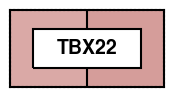

In [8]:
gene = gene_tcr[0]
    
# Define the data for the two blocks (0.0 is minimum, 1.0 is maximum color intensity)
# The order is: [Left_Block, Right_Block]
sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 

# Generate the plot
plot_gene_block(gene, sample_measurements, colormap='vlag', vmin=-0.9, vmax=0.9, incluster=True)#, output_filename='./results/for_TCR_schematics/'+gene+'.png')

In [152]:
de_summary_stats[de_summary_stats.target_name_corrected=='PTPN6']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
11105,ENSG00000111679,PTPN6,Stim8hr,344.0,0,2,2,-22.116832,True,305.890798,False,2-10 DE genes,on-target KD,ENSG00000111679,ENSG00000111679_Stim8hr,PTPN6
26396,ENSG00000111679,PTPN6,Stim48hr,369.0,2,2,4,-16.887258,True,206.924508,False,2-10 DE genes,on-target KD,ENSG00000111679,ENSG00000111679_Stim48hr,PTPN6
28299,ENSG00000111679,PTPN6,Rest,350.0,5,14,19,-13.492776,True,98.761511,False,>10 DE genes,on-target KD,ENSG00000111679,ENSG00000111679_Rest,PTPN6


In [172]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'NimbusSanL'

def plot_gene_block2(gene_name: str, measurements: np.ndarray, vmin=-0.8, vmax=0.8, colormap: str = 'Blues', incluster=True, output_filename: str = None):
    """
    Generates a 1x2 gene visualization block with a central gene name overlay.

    The color of each block (Left and Right) corresponds to the value in the 
    'measurements' array, mapped via the specified colormap.

    Args:
        gene_name (str): The name of the gene (e.g., 'MAP4K1').
        measurements (np.ndarray): A 1D NumPy array of two numerical values, 
                                   representing the measurement for each block.
                                   Structure: [Left_Block, Right_Block]
        colormap (str): The matplotlib colormap to use (e.g., 'Reds', 'viridis', etc.).
    """
    # 1. Setup the figure and axis
    # Adjusted figsize for a 1x2 horizontal look
    fig, ax = plt.subplots(figsize=(2, 1)) 
    
    # Reshape the 1D array (2 elements) into a 1x2 2D array for imshow.
    data_2d = measurements.reshape(1, 2)

    # 2. Plot the 1x2 data using imshow (creates the colored blocks)
    # extent=[xmin, xmax, ymin, ymax]. x runs from 0 to 2, y runs from 0 to 1.
    img = ax.imshow(data_2d, cmap=colormap, vmin=vmin, vmax=vmax, 
                    interpolation='nearest', extent=[0, 2, 0, 1]) 

    # 3. Apply plot aesthetics and add black line borders/separators
    ax.set_xticks([]) # Remove x ticks
    ax.set_yticks([]) # Remove y ticks

    if incluster:
        line_style = '-'
        line_width = 4
        font_weight = 'bold'
        custom_dashes = [2,0]
    else:
        line_style = '--'
        line_width = 4
        font_weight = 'normal'
        custom_dashes = [2,2]
    
    # Set all spines (outer borders) to be visible and black
    for spine in ax.spines.values():
        spine.set_linewidth(line_width)
        spine.set_linestyle(line_style)
        spine.set_edgecolor('black')
        spine.set_visible(True) # Ensure all four borders are visible
        spine.set_linestyle((0, custom_dashes))
    
    # Add a black vertical line to separate the two blocks (at x=1.0)
    
    line = Line2D([1.0, 1.0], [0, 1], color='black', linewidth=line_width/2, zorder=1)
    line.set_linestyle((0, custom_dashes)) # Apply custom dashes
    ax.add_line(line)

    # Ensure the aspect ratio and limits are correct
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1) # Y-limit is now 1 for the 1x2 shape

    # 4. Draw the central white box (Rectangle patch)
    # The center of the 1x2 grid is now at (1.0, 0.5)
    box_width = 1.4
    box_height = 0.5
    center_x = 1.0
    center_y = 0.5
    
    # Create the white rectangle
    rect = patches.Rectangle(
        (center_x - box_width/2, center_y - box_height/2),  # (x, y) starting point (bottom-left)
        box_width, 
        box_height,
        linewidth=line_width/2,
        linestyle=line_style,
        edgecolor='black', # Border color
        facecolor='white', # Fill color
        zorder=2 # Ensure the box is above the colored blocks
    )
    rect.set_linestyle((0, custom_dashes)) 
    ax.add_patch(rect)

    # 5. Add the gene name text
    ax.text(
        center_x, center_y, # Position at the center of the plot (1.0, 0.5)
        gene_name,
        color='black',
        fontsize=18,
        fontweight=font_weight,
        ha='center', # Horizontal alignment: Center
        va='center', # Vertical alignment: Center
        zorder=3 # Ensure text is above the white box
    )

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # 6. Show the plot (or save it)
    if output_filename:
        # Save the figure with tight bounding box and high resolution (300 DPI)
        plt.savefig(output_filename,
                    bbox_inches='tight',
                    pad_inches=0,
                    dpi=300)
        plt.close(fig) # Close the figure to free memory
        print(f"Figure successfully saved to {output_filename}")
    else:
        plt.show()

In [173]:
gene = 'IKGKG'
#sample_measurements = np.array([corr_stim8hr.loc[core_tcr, gene].mean(), corr_stim48hr.loc[core_tcr, gene].mean()]) 
plot_gene_block2(gene, sample_measurements, colormap='Grays', vmin=-1, vmax=2, incluster=False, output_filename='./results/for_TCR_schematics/'+gene+'.png')

Figure successfully saved to ./results/for_TCR_schematics/IKGKG.png


In [193]:
de_summary_stats[de_summary_stats.target_name=='CALCOCO2']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
7710,ENSG00000136436,CALCOCO2,Rest,476.0,2,3,5,-17.490059,True,85.345005,False,2-10 DE genes,on-target KD,ENSG00000136436,ENSG00000136436_Rest,CALCOCO2
15260,ENSG00000136436,CALCOCO2,Stim8hr,488.0,1793,559,2352,-13.131464,True,50.366554,False,>10 DE genes,on-target KD,ENSG00000136436,ENSG00000136436_Stim8hr,CALCOCO2
29340,ENSG00000136436,CALCOCO2,Stim48hr,424.0,364,120,484,-16.948319,True,103.527459,False,>10 DE genes,on-target KD,ENSG00000136436,ENSG00000136436_Stim48hr,CALCOCO2


In [194]:
de_by_guide[de_by_guide.target=='CALCOCO2']

,target,correlation,correlation_ceiling,n_signif,culture_condition
1068,CALCOCO2,0.081757,NaN,3723,Stim8hr
2178,CALCOCO2,0.324911,0.436109,800,Stim48hr


In [195]:
donor_robustness_summary[donor_robustness_summary.target_name=='CALCOCO2']

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
116,CALCOCO2,0.587174,0.508740,ENSG00000136436,Stim8hr,488.0,1793,559,2352,-13.131464,True,50.366554,False,>10 DE genes,on-target KD
103,CALCOCO2,0.504574,0.410098,ENSG00000136436,Stim48hr,424.0,364,120,484,-16.948319,True,103.527459,False,>10 DE genes,on-target KD


In [180]:
len(set(de_by_guide[(de_by_guide.target.isin(gene_tcr))&(de_by_guide.correlation>0.2)].target))

137

In [187]:
print(set(de_by_guide[(de_by_guide.target.isin(gene_tcr))&(de_by_guide.correlation>0.2)].target) & set(donor_robustness_summary[(donor_robustness_summary.target_name.isin(gene_tcr))&(donor_robustness_summary.donor_correlation_min>0)].target_name))

{'CDIPT', 'ADAT3', 'ATRX', 'NUDCD1', 'ATP2A2', 'CLDN7', 'FOXM1', 'RPE', 'EIF4G2', 'PHF23', 'TMEM263', 'EWSR1', 'LRP5', 'COG6', 'ATXN7L3', 'CD247', 'SZRD1', 'CD2', 'COPS9', 'NR4A3', 'TNRC6A', 'PGAP2', 'ARPC2', 'GSS', 'SNAP23', 'SIK3', 'CALCOCO2', 'FBXW2', 'EML2', 'RBM33', 'PGGT1B', 'KAT2B', 'ELOB', 'MTX2', 'ZNF837', 'DDX60L', 'USP22', 'TEAD4', 'ABCC1', 'CYB5R4', 'MEN1', 'CD3G', 'TMEM205', 'L2HGDH', 'KCTD21', 'NCBP3', 'AASDH', 'SENP1', 'HELT', 'SND1', 'HTT', 'GNE', 'PPHLN1', 'CAMSAP1', 'WAS', 'NDFIP2', 'UBIAD1', 'ORAI1', 'GPD1L', 'NUP37', 'CREBBP', 'TPGS2', 'CD28', 'RAVER1', 'KNOP1', 'FMR1', 'CEP89', 'PLIN4', 'DCAF5', 'TLN1', 'RAC2', 'EIF1', 'RPS6KA1', 'RNF8', 'PRKRA', 'C1D', 'MALT1', 'GPI', 'CLCC1', 'DOLPP1', 'OST4', 'TXNDC9', 'NATD1', 'BLOC1S4', 'TBRG1', 'TBL1XR1', 'ARL6IP1', 'FBXW7', 'TBX22', 'BRWD1', 'SHOC2', 'SRR', 'DNAJC8', 'ITK', 'FOXO1', 'NABP1', 'PEX5', 'PLCG1', 'CAPZA1', 'KMT5B', 'KIF14', 'SOCS4', 'MDM4', 'KAT6A', 'BRAT1', 'TP73', 'NKAPD1', 'METTL23', 'PCNX3', 'ZC3H10', 'STAT5A

In [200]:
np.sort(['CDIPT', 'ADAT3', 'NUDCD1', 'TBC1D31', 'ATP2A2', 'FOXM1',
          'CLDN7', 'RPE', 'NCAPG2', 'EIF4G2', 'PHF23', 'IKBKB', 'TMEM263', 'NFIC',
          'EWSR1', 'LRP5', 'ATXN7L3', 'HAPSTR1', 'SAXO5', 'AKR1A1', 'SZRD1', 'ACO2',
          'MCFD2', 'PPP1R10', 'COPS9', 'KIF16B', 'NR4A3', 'TNRC6A', 'LRIG1', 'PGAP2', 
          'GSS','VEZT', 'HACD4', 'CNOT6L', 'ATF7IP2', 'SRSF11', 'SIK3', 'EML2', 'FBXW2', 
          'RBM33', 'ZNF790', 'DCAF6', 'CBLL1', 'PGGT1B', 'ELOB', 'MTX2', 'BCAT2', 
          'ZNF837', 'DDX60L', 'USP22', 'TEAD4', 'ABCC1', 'DCAF4', 'CYB5R4', 'OSR1', 
          'SACM1L', 'MEN1', 'ICE2', 'NUSAP1', 'TMEM205', 'TENT2', 'L2HGDH', 'KCTD21', 
          'APPL2', 'PLEK2', 'NCBP3', 'AASDH', 'SENP1', 'HELT', 'SND1', 'SPATA33', 'USP7', 
          'HTT', 'DCAF11', 'JADE2', 'GNE', 'CAMSAP1', 'RNF19B', 'PPHLN1', 'NDFIP2', 'CHURC1',
          'UBIAD1', 'GPD1L', 'NUP37', 'UBL7', 'C11orf54', 'ARID4B', 'TPGS2', 'KGD4',
          'RAVER1', 'KNOP1', 'TBP', 'ARHGAP27', 'CEP89', 'FMR1', 'SPON1', 'PLIN4', 'SYK',
          'CSH1', 'ZFYVE26', 'FAM204A', 'CUL4A', 'DCAF5', 'HEXD', 'IKZF1', 'TASOR', 'ABHD17A',
          'TXNDC12', 'EIF1', 'RPS6KA1', 'TM2D2', 'RNF8', 'PRKRA', 'SCAF4', 'MAP3K5', 'MALT1',
          'MTA3', 'ANKK1', 'MTRES1', 'VPS29', 'C1D', 'GPI', 'CLCC1', 'TMEM140', 'CRIPT', 'DOLPP1',
          'PYGM', 'SLC9A5', 'OST4', 'TXNDC9', 'NATD1', 'TTF1', 'BLOC1S4', 'TBRG1', 'PDCD5', 'TBL1XR1', 'ADRM1', 
          'FBXW7', 'TBX22', 'BRWD1', 'SHOC2', 'AIRIM', 'PARP3', 'DNAAF5', 'SRR', 'SLC7A6', 'TMED9', 'SLC3A2',
          'TPRG1L', 'FLVCR2', 'DNAJC8', 'NABP1', 'PEX5', 'CAPZA1', 'PGBD2', 'NCAPD3', 'ANKRD61', 'BICDL1',
          'ELMOD3', 'BRAT1', 'TP73', 'COQ10B', 'CHN2', 'NKAPD1', 'PPDPF', 'ZSCAN23', 'FCHO1', 'PIBF1',
          'NADK2', 'ZBED3', 'HSD17B12', 'NFIX', 'PHF19', 'PCNX3', 'ZC3H10', 'FITM2', 'COLGALT1', 'GALNT6',
          'RIDA', 'NUP188', 'PPP3R1', 'ENTPD1', 'TMX1', 'TXNL1', 'TTC7A', 'MAF', 'ANKRD49','DNAJC3', 'PPM1D',
          'RPS6KA3', 'DTX4', 'KPNA4', 'ZNF384', 'UBE2E2', 'XRRA1', 'ANAPC10', 'CCDC134'])

array(['AASDH', 'ABCC1', 'ABHD17A', 'ACO2', 'ADAT3', 'ADRM1', 'AIRIM',
       'AKR1A1', 'ANAPC10', 'ANKK1', 'ANKRD49', 'ANKRD61', 'APPL2',
       'ARHGAP27', 'ARID4B', 'ATF7IP2', 'ATP2A2', 'ATXN7L3', 'BCAT2',
       'BICDL1', 'BLOC1S4', 'BRAT1', 'BRWD1', 'C11orf54', 'C1D',
       'CAMSAP1', 'CAPZA1', 'CBLL1', 'CCDC134', 'CDIPT', 'CEP89', 'CHN2',
       'CHURC1', 'CLCC1', 'CLDN7', 'CNOT6L', 'COLGALT1', 'COPS9',
       'COQ10B', 'CRIPT', 'CSH1', 'CUL4A', 'CYB5R4', 'DCAF11', 'DCAF4',
       'DCAF5', 'DCAF6', 'DDX60L', 'DNAAF5', 'DNAJC3', 'DNAJC8', 'DOLPP1',
       'DTX4', 'EIF1', 'EIF4G2', 'ELMOD3', 'ELOB', 'EML2', 'ENTPD1',
       'EWSR1', 'FAM204A', 'FBXW2', 'FBXW7', 'FCHO1', 'FITM2', 'FLVCR2',
       'FMR1', 'FOXM1', 'GALNT6', 'GNE', 'GPD1L', 'GPI', 'GSS', 'HACD4',
       'HAPSTR1', 'HELT', 'HEXD', 'HSD17B12', 'HTT', 'ICE2', 'IKBKB',
       'IKZF1', 'JADE2', 'KCTD21', 'KGD4', 'KIF16B', 'KNOP1', 'KPNA4',
       'L2HGDH', 'LRIG1', 'LRP5', 'MAF', 'MALT1', 'MAP3K5', 'MCFD2',
       'MEN1',

In [33]:
corr_stim8hr

,NFKBIA,ADAT3,CDIPT,PDPK1
NFKBIA,NaN,-0.225284,0.129626,-0.094863
ADAT3,-0.225284,NaN,0.246407,-0.042858
CDIPT,0.129626,0.246407,NaN,-0.039339
PDPK1,-0.094863,-0.042858,-0.039339,NaN


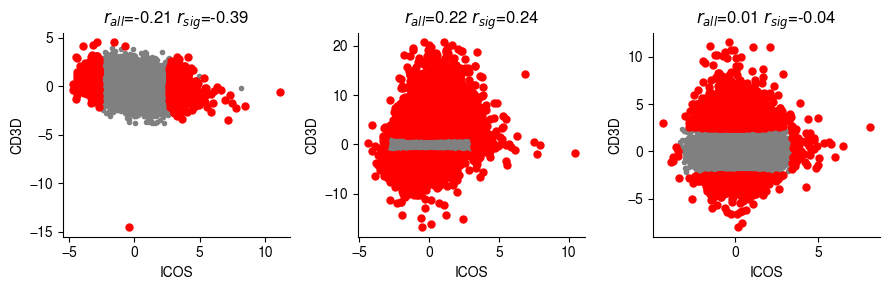

In [162]:
genelist =['ICOS', 'CD3D']
fig, ax = plt.subplots(1,3,figsize=(9,3))
for i, cond in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
    cond_mask = adata_de.obs['culture_condition']==cond
    target_gene_mask = ~adata_de.var['gene_name'].isin(genelist)
    gene1_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['zscore'][0].copy()
    gene1_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['adj_p_value'][0].copy()
    gene2_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['zscore'][0].copy()
    gene2_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['adj_p_value'][0].copy()
    sig_mask = (gene1_padj<0.1)|(gene2_padj<0.1)
    ax[i].plot(gene1_zscore[~sig_mask], gene2_zscore[~sig_mask], '.', color='gray')
    ax[i].plot(gene1_zscore[sig_mask], gene2_zscore[sig_mask], '.', color='red', markersize=10)
    ax[i].set_xlabel(genelist[0])
    ax[i].set_ylabel(genelist[1])
    result_all = pearsonr(gene1_zscore, gene2_zscore)
    result_sig = pearsonr(gene1_zscore[sig_mask], gene2_zscore[sig_mask])
    ax[i].set_title(r'$r_{all}$='+f'{result_all.statistic:.2f} '+r'$r_{sig}$='+f'{result_sig.statistic:.2f}')
sns.despine()
plt.tight_layout()

In [89]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='DGK1'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan,hdbscan_cluster_size,hdbscan_cluster_gene_size,hdbscan_corr_rest_over_corr_all,hdbscan_corr_stim8hr_over_corr_all,hdbscan_corr_stim48hr_over_corr_all


In [81]:
print(adata_final[adata_final.obs.hdbscan==37].obs['target_contrast_gene_name_corrected'].tolist())

['PLAT', 'LCK', 'PTPRC', 'SKIC2', 'TMX1', 'SLC3A2', 'UBE2E2', 'LRBA', 'HACD4', 'CALCOCO2', 'FITM2', 'PGGT1B', 'MTA3', 'ITK', 'APPL2', 'GPRASP1', 'NDFIP2', 'PLEK2', 'ARHGAP27', 'MBD5', 'EML2', 'RAC2', 'CAMSAP1', 'RAB19', 'DCAF11', 'TMEM205', 'SYK', 'TXNDC12', 'CRIPT', 'UBL7', 'CSH1', 'DCAF6', 'PPP3R1', 'WAS', 'PHF19', 'ABCC1', 'SHOC2', 'FLVCR2', 'BRWD1', 'KIF16B', 'SLC7A6', 'ZSCAN23', 'RAVER1', 'TASOR', 'ARID4B', 'JADE2', 'KCTD21', 'ANKRD61', 'MCFD2', 'HSD17B12', 'NFIX', 'TBC1D31', 'KAT6A', 'PGBD2', 'TLN1', 'SNAP29', 'DDX60L', 'TBX22', 'ARPC2', 'ADRM1', 'CDIPT', 'ABHD17A', 'NCBP3', 'ORAI2', 'TTC7A', 'PPP1R10', 'SPATA33', 'KPNA4', 'GPD1L', 'PEX5', 'TBP', 'DEF6', 'RBM33', 'LRIG1', 'TTF1', 'DTX4', 'AKR1A1', 'RNF19B', 'BLOC1S4', 'TMED9', 'TXNL1', 'NABP1', 'FBXW2', 'ATP2A2', 'MBD2', 'HEXD', 'CHURC1', 'SOS2', 'PLIN4', 'VPS35', 'UBIAD1', 'ANKK1', 'DNAJC8', 'ORAI1', 'COG6', 'ACO2', 'USP22', 'NUDCD1', 'ATXN7L3', 'PLCG1', 'CD247', 'LCP2', 'ZAP70', 'CD3G', 'VAV1', 'ZBED3', 'BCAT2', 'CD3D', 'CD3E',

In [ ]:
adata_final[adata_final.obs.hdbscan==109].obs.sort_values(by='target_contrast_gene_name_corrected')

In [ ]:
adata_final[adata_final.obs.hdbscan==37].obs.sort_values(by='target_contrast_gene_name_corrected')